In [26]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
# ! pip install pgmpy

In [28]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [29]:
import pandas as pd
import numpy as np

import common

In [30]:
data_set_path = "../temp_sets_100/"

# icustays

## Read samples

In [31]:
icustays_df = common.read_csv_no_rowid(data_set_path+"icustays.csv")

In [32]:
icustays_df['icustay_id'].value_counts()

268209    1
276223    1
226689    1
237618    1
279581    1
         ..
233264    1
207733    1
240963    1
210678    1
247962    1
Name: icustay_id, Length: 156, dtype: int64

## Data preproces

In [33]:
# Drop useless colums
icustays_df.drop(['los'], axis=1, inplace=True)

### Process null values

In [34]:
# Check null value in table
common.nan_count(icustays_df)

Total columns: 10
Total rows: 156
--------------
subject_id        0
hadm_id           0
icustay_id        0
dbsource          0
first_careunit    0
last_careunit     0
first_wardid      0
last_wardid       0
intime            0
outtime           0
dtype: int64


### Set the column types

In [35]:
icustays_df.dtypes

subject_id         int64
hadm_id            int64
icustay_id         int64
dbsource          object
first_careunit    object
last_careunit     object
first_wardid       int64
last_wardid        int64
intime            object
outtime           object
dtype: object

In [36]:
# Transfer some date type
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

In [37]:
icustays_df.dtypes

subject_id                 int64
hadm_id                    int64
icustay_id                 int64
dbsource                  object
first_careunit            object
last_careunit             object
first_wardid               int64
last_wardid                int64
intime            datetime64[ns]
outtime           datetime64[ns]
dtype: object

### Process time value

In [38]:
admissions_df = common.read_csv_no_rowid(data_set_path+"admissions.csv")

In [39]:
admittime_df = admissions_df.loc[:, ['hadm_id', 'admittime']]
admittime_df['admittime'] = pd.to_datetime(admittime_df['admittime'])

In [40]:
icustays_mid_df = pd.merge(left=icustays_df, right=admittime_df, how='left', on=['hadm_id'])

In [41]:
icustays_mid_df['outtime'] = icustays_mid_df.apply(common.time_process, args=('intime', 'outtime'), axis=1)
icustays_mid_df['intime'] = icustays_mid_df.apply(common.time_process, args=('admittime', 'intime'), axis=1)

In [42]:
icustays_df = icustays_mid_df.drop(['subject_id', 'hadm_id', 'admittime'], axis=1)

In [43]:
icustays_df.columns

Index(['icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

---

##  Build Network

In [44]:
from sdv.tabular import CTGAN


In [45]:
icustays_df.columns

Index(['icustay_id', 'dbsource', 'first_careunit', 'last_careunit',
       'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

### Set constraint

In [46]:
# def time_is_valid(column_names, data):
#     intime_outtime = ((data['outtime'] - data['intime']).apply(lambda x: 0 <= x.days  <= 365))
    
#     return intime_outtime

# def time_trasform(column_names, data):
#     # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
#     return data

# def time_reverse_transform(column_names, transformed_data):
#     transformed_data['intime'] = pd.to_datetime(transformed_data['intime'])
#     transformed_data['outtime'] = pd.to_datetime(transformed_data['outtime'])

#     return transformed_data

In [47]:
# TimeProcess = create_custom_constraint(
#     is_valid_fn=time_is_valid,
#     transform_fn=time_trasform,
#     reverse_transform_fn=time_reverse_transform
# )

# time_constraint = TimeProcess(
#     column_names=['intime', 'outtime']
# )

In [48]:
from sdv.constraints import Unique

unique_icustay_id_constraint = Unique(
    column_names=['icustay_id']
)

In [49]:
constraints = [unique_icustay_id_constraint]

### Build and train model

In [50]:
train_data = icustays_df
best_model = common.build_model(constraints=constraints, train_data=train_data)

Strat training ...
Tabular Preset


Sampling rows: 100%|██████████| 156/156 [00:00<00:00, 5751.78it/s]


Gaussian Copula


Sampling rows: 100%|██████████| 156/156 [00:00<00:00, 10025.46it/s]

CTGAN



Sampling rows: 100%|██████████| 156/156 [00:00<00:00, 2719.78it/s]


CopulaGAN


Sampling rows: 100%|██████████| 156/156 [00:00<00:00, 5049.83it/s]


TVAE


Sampling rows: 100%|██████████| 156/156 [00:00<00:00, 3194.79it/s]


Training finished!
Strat evaluating ...
Evaluating finished!
Gaussian Copula


Sampling rows: 100%|██████████| 156/156 [00:00<00:00, 10742.80it/s]


The ContinuousKL_score is: 0.171569780505133
The DiscreteKL_score is: 0.43915592796234554
The total score is: 0.380799053795166


In [51]:
model_save_path = data_set_path + "100_models/" + "icustays_model.pkl"
common.save_model(best_model, model_save_path)

---

## Evaluate data

In [52]:
from sdv.evaluation import evaluate

### Generate synthetic data

In [53]:
# Load model
date_load_path = data_set_path + "100_models/" + "icustays_model.pkl"
model = common.load_model(date_load_path)

In [54]:
sample = model.sample(100)

Sampling rows: 100%|██████████| 100/100 [00:00<00:00, 6623.14it/s]


In [55]:
sample.head()

,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime
0,259972,carevue,MICU,MICU,41,39,183965.0,1722916.0
1,249378,metavision,MICU,MICU,14,19,873022.0,3196034.0
2,237404,metavision,SICU,MICU,23,27,250576.0,681288.0
3,240241,metavision,CCU,SICU,25,29,307052.0,1712873.0
4,281759,carevue,CCU,MICU,29,47,694626.0,252502.0


In [56]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.605516018428267

In [57]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.1723591540165364

In [58]:
sample['dbsource'].value_counts()

carevue       59
metavision    41
Name: dbsource, dtype: int64

<AxesSubplot:>

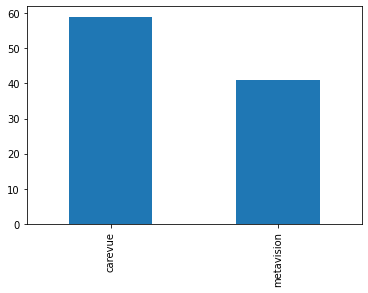

In [59]:
sample['dbsource'].value_counts().plot.bar()

In [60]:
train_data['dbsource'].value_counts()

carevue       101
metavision     55
Name: dbsource, dtype: int64

<AxesSubplot:>

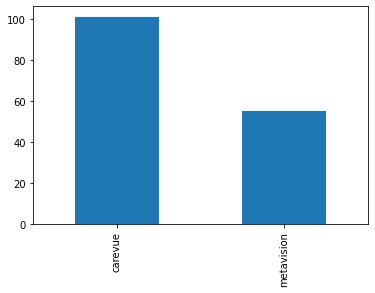

In [61]:
train_data['dbsource'].value_counts().plot.bar()